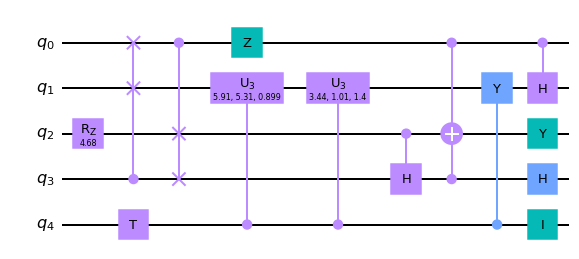

In [2]:
import qiskit.quantum_info as qi
from qiskit.circuit.random import random_circuit
import qiskit.circuit.library.standard_gates as g
import qiskit.circuit.quantumcircuit as qc
from itertools import product, combinations_with_replacement

circ = random_circuit(5, 5, measure=False)

from qiskit.ignis.verification import get_ghz_simple
#circ = get_ghz_simple(3,measure=False)
circ.draw(output='mpl')
# for gate in circ.data:
#     print('\ngate name:', gate[0].name)
#     print('qubit(s) acted on:', gate[1])
#     print('other paramters (such as angles):', gate[0].params)

In [3]:
#iterate over all gates
#if an I, won't be present
#g[0] contains the gate
# g[1] contains the qubit (or a list where control is first by convention (?))
#use circ.num_qubits to iterate
num_qubits = circ.num_qubits
gate_list = num_qubits * [None]
index_list = num_qubits * [0]
for g in circ.data:
    for b in g[1]:
        #print(b.index)
        if gate_list[b.index] != -1 or ():
            for c in gate_list:
                if c == -1:
                    c = "I"
            print(gate_list)
            gate_list = num_qubits * [-1]
        gate_list[b.index] = g[0].name
        #print(g[0].name)
        

/tmp/ipykernel_69870/1566726436.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if gate_list[b.index] != -1:
/tmp/ipykernel_69870/1566726436.py:17: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  gate_list[b.index] = g[0].name
/tmp/ipykernel_69870/1566726436.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if gate_list[b.index] != -1:


['cswap', 'cswap', 'rz', 'cswap', 't']
['cswap', 'cu3', 'cswap', 'cswap', 'cu3']
['z', 'cu3', 'ch', 'ch', 'cu3']
['ccx', 'cy', 'ccx', 'ccx', 'cy']


/tmp/ipykernel_69870/1566726436.py:17: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  gate_list[b.index] = g[0].name


In [44]:
def circuitPrint(circuit):
    """custom print method that does not print identity gates"""
    #TODO: no easy way except for creating a temporary circuit and don't copy over I gates?
    temp_str = circuit.__str__()
    print(temp_str)

t1 = qc.QuantumCircuit(2)
t1.x(0)
t1.i(0)
t1.i(1)
t1.x(1)
circuitPrint(t1)

     ┌───┐┌───┐
q_0: ┤ X ├┤ I ├
     ├───┤├───┤
q_1: ┤ I ├┤ X ├
     └───┘└───┘


In [3]:
# #TODO: Refactor this code to be wrapped into a class
#TODO: what is this? import qiskit.circuit.equivalence_library
import qiskit.extensions as qe
import numpy as np

#deprecated
# #temporary flipping of cnots
# class xc(qe.UnitaryGate):
#     def __init__(self):
#         super().__init__(data = np.array([[1,0,0,0], [0,0,0,1], [0,0,1,0], [0,1,0,0]]), label="XC")

class rootSwap(qe.UnitaryGate):
    def __init__(self):
        super().__init__(data= np.array([[1,0,0,0], [0, .5*(1+1j), .5*(1-1j), 0], [0, .5*(1-1j), .5*(1+1j), 0], [0,0,0,1]]), label=r"$\sqrt{SWAP}$")

In [4]:
#TODO: extend to multiqubit gates
#this code is not that smart
#multiQ need to vary between all controls and all targets

def generate_all(gate_set, window, print_output=False):
    #TODO: would be smart in class implementation to start with just gate_set from the circuit
    #and have a separate gate_set from the set to decompose into, then do matches between the hashes
    
    """Generate all the possible circuits of the quantum circuits using the gate set
    window = (width, height)
    this gate_set needs to contain all gates in the given circuits as well as gates you wish to decompose into"""

    circuit_list = []

    def foo(gate_set, height):
        #for multiqubit gates, need to select total of r qubit operands
        #eg CX counts as 2 to total qubit operants
        #this is not exactly accurate, but assume CX is only with 1 control bit
        #TODO: refactor hardcoding

        #perms is a list of possible bars
        gate_perms = []
        #use repeat as height because each gate is atleast 1 height so upperbound
        for gate_comb in product(gate_set, repeat=height):
            operands = 0
            temp_gate_perm = []

            for gate in gate_comb:
                temp_gate_perm.append(gate)

                if gate in [g.IGate, g.HGate, g.XGate, g.YGate, g.ZGate]:
                    operands += 1
                elif gate in [g.CXGate, g.SwapGate, rootSwap, g.CZGate]:
                    #by adding height, forces 2 qubit gates to only be put in gate_perm if they are at firstt
                    operands +=height
                    #TODO: only allow 1 2-qubit gate per bar(?)
                    #operands +=2

                else:
                    raise NotImplementedError
                
                if operands == height:
                    #avoid duplicates
                    if temp_gate_perm not in gate_perms:
                        gate_perms.append(temp_gate_perm)
                    break
                if operands > height:
                    break

        return gate_perms


    #before taking product need to modify gate_set so includes permutations of control and target qubits
    gate_perms = foo(gate_set, window[1])
    gate_perms_2qubitwithtargets = []
    for gate_bar in gate_perms:
        if len(gate_bar) ==1:
            control = 0
            target = 0

            #for swap-family gates dont permuate control and target
            if gate_bar[0] in [g.CXGate]:
                for control in range(0, window[1]):
                    for target in range(0, window[1]):
                        if control != target:
                            temp_gate_bar = []
                            temp_gate_bar.append((gate_bar[0],[control,target]))

                            #add missing Is - not if in between gate?
                            for qb in range(window[1]):
                                if qb < min(control, target) or qb > max(control,target):
                                    temp_gate_bar.append((g.IGate, [qb]))
                            gate_perms_2qubitwithtargets.append(temp_gate_bar)


            else:
                for control in range(0, window[1]):
                    for target in range(control+1, window[1]):
                        temp_gate_bar = []
                        temp_gate_bar.append((gate_bar[0],[control,target]))
                        
                        #add missing Is - not if in between gate?
                        for qb in range(window[1]):
                            if qb < min(control, target) or qb > max(control,target):
                                temp_gate_bar.append((g.IGate, [qb]))
                        gate_perms_2qubitwithtargets.append(temp_gate_bar)
        
        else:
            temp_gate_bar = []
            for qubit_index in range(window[1]):
                temp_gate_bar.append((gate_bar[qubit_index], [qubit_index]))
            gate_perms_2qubitwithtargets.append(temp_gate_bar)

    for gate_perm in product(gate_perms_2qubitwithtargets, repeat=window[0]):
        temp = qc.QuantumCircuit(window[1])
        for gate_bar in gate_perm:
            
            for gate in gate_bar:
                temp.append(gate[0](), gate[1])

            # #WIP refactor hardcoding, only places CNOT in 0,1
            # #because force height of 2 qubit gates to be == height, we can make permutations here
            # #only allowing bars that have 1 qubit gate and IGates elsewhere
            # if gate_bar[0]:
            #     pass

            # #this deprecates xc gates because now we can modify control and target
            #     # #flip for XCs
            #     # if gate_bar[0] == xc:
            #     #     temp.cx(target,control)
            #     # else:
            #     #     temp.append(gate_bar[0](),[control,target])
            
            # else:
            #     for qubit_index in range(window[1]):
            #         temp.append(gate_bar[qubit_index](), [qubit_index])
           

        circuit_list.append(temp)

        if print_output:
            print(temp)

    return circuit_list

circuit_list = generate_all(gate_set = [g.CXGate, g.XGate], window = (3,3), print_output=False)
print(len(circuit_list))
for circ in circuit_list:
    print(circ)

343
                    
q_0: ──■────■────■──
     ┌─┴─┐┌─┴─┐┌─┴─┐
q_1: ┤ X ├┤ X ├┤ X ├
     ├───┤├───┤├───┤
q_2: ┤ I ├┤ I ├┤ I ├
     └───┘└───┘└───┘
                    
q_0: ──■────■────■──
     ┌─┴─┐┌─┴─┐  │  
q_1: ┤ X ├┤ X ├──┼──
     ├───┤├───┤┌─┴─┐
q_2: ┤ I ├┤ I ├┤ X ├
     └───┘└───┘└───┘
               ┌───┐
q_0: ──■────■──┤ X ├
     ┌─┴─┐┌─┴─┐└─┬─┘
q_1: ┤ X ├┤ X ├──■──
     ├───┤├───┤┌───┐
q_2: ┤ I ├┤ I ├┤ I ├
     └───┘└───┘└───┘
               ┌───┐
q_0: ──■────■──┤ I ├
     ┌─┴─┐┌─┴─┐└───┘
q_1: ┤ X ├┤ X ├──■──
     ├───┤├───┤┌─┴─┐
q_2: ┤ I ├┤ I ├┤ X ├
     └───┘└───┘└───┘
               ┌───┐
q_0: ──■────■──┤ X ├
     ┌─┴─┐┌─┴─┐└─┬─┘
q_1: ┤ X ├┤ X ├──┼──
     ├───┤├───┤  │  
q_2: ┤ I ├┤ I ├──■──
     └───┘└───┘     
               ┌───┐
q_0: ──■────■──┤ I ├
     ┌─┴─┐┌─┴─┐├───┤
q_1: ┤ X ├┤ X ├┤ X ├
     ├───┤├───┤└─┬─┘
q_2: ┤ I ├┤ I ├──■──
     └───┘└───┘     
               ┌───┐
q_0: ──■────■──┤ X ├
     ┌─┴─┐┌─┴─┐├───┤
q_1: ┤ X ├┤ X ├┤ X ├
     ├───┤├───┤├───┤
q_2: ┤ I 

In [7]:
def _circuitToHash(circuit):
    #see Fig. 7 of Quanto paper
    #TODO: my string is not yet formatted with brackets, maybe will break multiqubit gates?
    #circuit_key = " ".join([gate[0].name for gate in circuit.data])
    circuit_key = str(circuit)
    return circuit_key

def generate_fingerprints(circuit_list):
    """Calculate the unitary matrices and generate their fingerprints"""
    fingerprint_dict = {}
    for circuit in circuit_list:
        circuit_key = _circuitToHash(circuit)
        #rounding unitary matrix so values like .99999999 have same hash as 1.0
        unitary_value = hash(np.around(qi.Operator(circuit).data, decimals=8).tobytes())
        
        fingerprint_dict[circuit_key] = unitary_value
    return fingerprint_dict


fingerprint_dict = generate_fingerprints(circuit_list)

In [8]:
def generate_circuitIdentities(circuit_list, fingerprint_dict):
    """The hash table of substitutions includes the fingerprints as keys
    and an array of matching circuit identities as values."""
    identity_dict = {}
    for circuit in circuit_list:
        circuit_key = _circuitToHash(circuit)
        finger_key = fingerprint_dict[circuit_key]
        #if key exists, append it to the list
        if finger_key in identity_dict.keys():
            identity_dict[finger_key].append(circuit)

        #otherwise, create new identity entry
        else:
            identity_dict[finger_key] = [circuit]
    
    return identity_dict

identity_dict = generate_circuitIdentities(circuit_list, fingerprint_dict)

In [24]:
circuit_list = generate_all(gate_set = [g.IGate,g.CXGate, g.SwapGate, rootSwap], window = (3,2), print_output=False)
fingerprint_dict = generate_fingerprints(circuit_list)
identity_dict = generate_circuitIdentities(circuit_list, fingerprint_dict)

print(f"Reduced {len(circuit_list)} circuits to {len(identity_dict.keys())} identities")
for index, key in enumerate(identity_dict):
    print(f"Identity {index}")
    print(qi.Operator(identity_dict[key][0]).data)
    for circuit in identity_dict[key]:
        print(circuit)
    

Reduced 125 circuits to 22 identities
Identity 0
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
     ┌───┐┌───┐┌───┐
q_0: ┤ I ├┤ I ├┤ I ├
     ├───┤├───┤├───┤
q_1: ┤ I ├┤ I ├┤ I ├
     └───┘└───┘└───┘
     ┌───┐          
q_0: ┤ I ├──■────■──
     ├───┤┌─┴─┐┌─┴─┐
q_1: ┤ I ├┤ X ├┤ X ├
     └───┘└───┘└───┘
     ┌───┐┌───┐┌───┐
q_0: ┤ I ├┤ X ├┤ X ├
     ├───┤└─┬─┘└─┬─┘
q_1: ┤ I ├──■────■──
     └───┘          
     ┌───┐      
q_0: ┤ I ├─X──X─
     ├───┤ │  │ 
q_1: ┤ I ├─X──X─
     └───┘      
          ┌───┐     
q_0: ──■──┤ I ├──■──
     ┌─┴─┐├───┤┌─┴─┐
q_1: ┤ X ├┤ I ├┤ X ├
     └───┘└───┘└───┘
               ┌───┐
q_0: ──■────■──┤ I ├
     ┌─┴─┐┌─┴─┐├───┤
q_1: ┤ X ├┤ X ├┤ I ├
     └───┘└───┘└───┘
     ┌───┐┌───┐┌───┐
q_0: ┤ X ├┤ I ├┤ X ├
     └─┬─┘├───┤└─┬─┘
q_1: ──■──┤ I ├──■──
          └───┘     
     ┌───┐┌───┐┌───┐
q_0: ┤ X ├┤ X ├┤ I ├
     └─┬─┘└─┬─┘├───┤
q_1: ──■────■──┤ I ├
               └───┘
      

In [25]:
#need to sort circuits by a cost function
#TODO: more 2 qubit gates increases cost (?)
def sort_identities(identity_list):
    #start simple, count number of identity gates
    _count_identity = lambda circ : sum([isinstance(gate[0], g.IGate) for gate in circ])
    return sorted(identity_list, key = lambda x: _count_identity(x), reverse=True)

In [27]:
def _getIdentity(identity_dict, fingerprint_dict, circuit, gate_set=None):
    """Given a circuit, returns a list of equivalent circuits
    optional- specify a gate_set to only include circuits with that gate_set
    ie dont want to decompose a gate into a circuit made up of itself"""
    
    circuit_key = _circuitToHash(circuit)
    finger_key = fingerprint_dict[circuit_key]
    #if gate_set is not None, only return circuits that contain gates from the set
    identities = identity_dict[finger_key]
    if gate_set != None:
        restricted_identities = []
        for circuit in identities:
            if all([any([isinstance(circuit_gate[0], gate_set_el) for gate_set_el in gate_set]) for circuit_gate in circuit]):
                restricted_identities.append(circuit)
        return restricted_identities
    else:
        return identities

circ = qc.QuantumCircuit(2)
circ.i(0)
circ.i(1)
circ.swap(0,1)
circ.i(0)
circ.i(1)

circ2 = qc.QuantumCircuit(2)
circ2.cx(0,1)
circ2.cx(1,0)
circ2.cx(0,1)

print("Given this circuit")
print(circ)
# equivalence_list =_getIdentity(identity_dict, fingerprint_dict, circ)
# print(f"Found the following {len(equivalence_list)} equivalent circuits")
# for circuit in equivalence_list:
#     print(circuit)

#example, build swap gate without swap gate
restricted_list = _getIdentity(identity_dict, fingerprint_dict, circ, gate_set = [g.IGate,g.CXGate, g.HGate])
print(f"Found the following {len(restricted_list)} restricted equivalent circuits")
for circuit in restricted_list:
    print(circuit)

print("Given this circuit")
print(circ2)
#example, build cnots from swap
restricted_list = _getIdentity(identity_dict, fingerprint_dict, circ2, gate_set = [g.IGate, g.SwapGate, g.HGate])
#sorted so restricted[0] has most identity gates
restricted_list = sort_identities(restricted_list)
print(f"Found the following {len(restricted_list)} restricted equivalent circuits")
for circuit in restricted_list:
    print(circuit)

Given this circuit
     ┌───┐   ┌───┐
q_0: ┤ I ├─X─┤ I ├
     ├───┤ │ ├───┤
q_1: ┤ I ├─X─┤ I ├
     └───┘   └───┘
Found the following 2 restricted equivalent circuits
          ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘
     ┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     └─┬─┘┌─┴─┐└─┬─┘
q_1: ──■──┤ X ├──■──
          └───┘     
Given this circuit
          ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘
Found the following 4 restricted equivalent circuits
     ┌───┐┌───┐   
q_0: ┤ I ├┤ I ├─X─
     ├───┤├───┤ │ 
q_1: ┤ I ├┤ I ├─X─
     └───┘└───┘   
     ┌───┐   ┌───┐
q_0: ┤ I ├─X─┤ I ├
     ├───┤ │ ├───┤
q_1: ┤ I ├─X─┤ I ├
     └───┘   └───┘
        ┌───┐┌───┐
q_0: ─X─┤ I ├┤ I ├
      │ ├───┤├───┤
q_1: ─X─┤ I ├┤ I ├
        └───┘└───┘
              
q_0: ─X──X──X─
      │  │  │ 
q_1: ─X──X──X─
              


In [12]:
circ = get_ghz_simple(3, measure=False)
circuit_list = generate_all(gate_set = [g.IGate,g.CXGate, rootSwap, g.HGate], window = (2,3), print_output=False)
fingerprint_dict = generate_fingerprints(circuit_list)
identity_dict = generate_circuitIdentities(circuit_list, fingerprint_dict)

In [21]:
def _getIdentity(identity_dict, fingerprint_dict, circuit, gate_set=None):
    """Given a circuit, returns a list of equivalent circuits
    optional- specify a gate_set to only include circuits with that gate_set
    ie dont want to decompose a gate into a circuit made up of itself"""
    
    circuit_key = _circuitToHash(circuit)
    finger_key = fingerprint_dict[circuit_key]
    #if gate_set is not None, only return circuits that contain gates from the set
    identities = identity_dict[finger_key]
    if gate_set != None:
        restricted_identities = []
        for circuit in identities:
            if all([any([isinstance(circuit_gate[0], gate_set_el) for gate_set_el in gate_set]) for circuit_gate in circuit]):
                restricted_identities.append(circuit)
        return restricted_identities
    else:
        return identities

circ = qc.QuantumCircuit(3)
circ.h(0)
circ.i(1)
circ.i(2)

circ.cx(0,1)
circ.i(2)

# circ.i(0)
# circ.cx(1,2)

circ2 = qc.QuantumCircuit(3)
# circ2.h(0)
# circ2.i(1)
# circ2.i(2)

circ2.cx(0,1)
circ2.i(2)

circ2.i(0)
circ2.cx(1,2)


print("Given this circuit")
print(circ)
# equivalence_list =_getIdentity(identity_dict, fingerprint_dict, circ)
# print(f"Found the following {len(equivalence_list)} equivalent circuits")
# for circuit in equivalence_list:
#     print(circuit)

#example, build swap gate without swap gate
restricted_list = _getIdentity(identity_dict, fingerprint_dict, circ, gate_set = None)
print(f"Found the following {len(restricted_list)} restricted equivalent circuits")
for circuit in restricted_list:
    print(circuit)

print("Given this circuit")
print(circ2)
#example, build cnots from swap
restricted_list = _getIdentity(identity_dict, fingerprint_dict, circ2, gate_set = None)
#sorted so restricted[0] has most identity gates
restricted_list = sort_identities(restricted_list)
print(f"Found the following {len(restricted_list)} restricted equivalent circuits")
for circuit in restricted_list:
    print(circuit)

Given this circuit
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ I ├┤ X ├
     ├───┤├───┤
q_2: ┤ I ├┤ I ├
     └───┘└───┘
Found the following 1 restricted equivalent circuits
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ I ├┤ X ├
     ├───┤├───┤
q_2: ┤ I ├┤ I ├
     └───┘└───┘
Given this circuit
          ┌───┐
q_0: ──■──┤ I ├
     ┌─┴─┐└───┘
q_1: ┤ X ├──■──
     ├───┤┌─┴─┐
q_2: ┤ I ├┤ X ├
     └───┘└───┘
Found the following 1 restricted equivalent circuits
          ┌───┐
q_0: ──■──┤ I ├
     ┌─┴─┐└───┘
q_1: ┤ X ├──■──
     ├───┤┌─┴─┐
q_2: ┤ I ├┤ X ├
     └───┘└───┘


In [13]:
#TODO: before building subcircuit, need to place in identities (?) before or after finding subcircuit
window = (2,3)
for w in range(window[0]):
    for h in range(window[1]):
        #build subcircuit
        print("")

(<qiskit.circuit.library.standard_gates.h.HGate object at 0x7f22cbf6d880>, [Qubit(QuantumRegister(3, 'q'), 0)], [])
(<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f22a93348e0>, [Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)], [])
(<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f22cbf6dbb0>, [Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)], [])
(<qiskit.circuit.library.standard_gates.h.HGate object at 0x7f22cbf6d880>, [Qubit(QuantumRegister(3, 'q'), 0)], [])
(<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f22a93348e0>, [Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)], [])
(<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f22cbf6dbb0>, [Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)], [])
     ┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘








In [ ]:
# # c1 = _circuitToHash(circ)
# # c2 = _circuitToHash(circ2)
# # print(c1)
# # print(c2)
# print(circ)
# print(qi.Operator(circ).data)
# print(_circuitToHash(circ))
# print(hash(qi.Operator(circ).data.tobytes()))
# print(fingerprint_dict[_circuitToHash(circ)])

# print(circ2)
# print(qi.Operator(circ2).data)
# print(_circuitToHash(circ2))
# print(hash(qi.Operator(circ2).data.tobytes()))
# print(fingerprint_dict[_circuitToHash(circ2)])


# [c for c in identity_dict[5901377612629326771]]
# for c in identity_dict[5901377612629326771]:
#     print(c)